In [65]:
import sys
import os

project_root = os.path.abspath(os.path.join('..', '..', '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from cyberattacks_detection.models import RBFNN, ELM, ModelWrapper, min_max_scale, reverse_min_max_scale
from sklearn.linear_model import LinearRegression
import mlflow
import pickle
import pandas as pd
import re
from sklearn import metrics
import matplotlib.pyplot as plt

In [3]:
mlflow.set_tracking_uri("http://localhost:5000")

In [84]:
save_mode = True

In [4]:
model_path = "../../saved_models/"

# Load and save

## LR

In [29]:
lr1 = mlflow.sklearn.load_model("runs:/95d5e81609ab4d82b1d83a216f56c67f/LR")
lr2 = mlflow.sklearn.load_model("runs:/4d89da3581d14d58b3e08a47372a27f5/LR")
lr3 = mlflow.sklearn.load_model("runs:/fbd579e963d14913a2e461acb4d8403f/LR")
lr4 = mlflow.sklearn.load_model("runs:/4a128bad1cc64e768ceb4fdce529e78f/LR")

In [30]:
if save_mode:
    pickle.dump(lr1, open(os.path.join(model_path, "lr_x1.sav"), 'wb'))
    pickle.dump(lr2, open(os.path.join(model_path, "lr_x2.sav"), 'wb'))
    pickle.dump(lr3, open(os.path.join(model_path, "lr_x3.sav"), 'wb'))
    pickle.dump(lr4, open(os.path.join(model_path, "lr_x4.sav"), 'wb'))

## RBFNN

In [85]:
rbf_nn1 = mlflow.pyfunc.load_model("runs:/60821cd712a343379e652d3625b8763a/RBF")
rbf_nn1 = rbf_nn1.unwrap_python_model().model
rbf_nn2 = mlflow.pyfunc.load_model("runs:/5c4091b6099b494f86627bf19ef73bb0/RBF")
rbf_nn2 = rbf_nn2.unwrap_python_model().model
rbf_nn3 = mlflow.pyfunc.load_model("runs:/9405923f128a4b7288da70cd08dd0e2c/RBF")
rbf_nn3 = rbf_nn3.unwrap_python_model().model
rbf_nn4 = mlflow.pyfunc.load_model("runs:/fd808b8e7cad4430947f3a7524423118/RBF")
rbf_nn4 = rbf_nn4.unwrap_python_model().model

In [86]:
if save_mode: 
    rbf_nn1.save_model(os.path.join(model_path, "rbf_x1.npz"))
    rbf_nn2.save_model(os.path.join(model_path, "rbf_x2.npz"))
    rbf_nn3.save_model(os.path.join(model_path, "rbf_x3.npz"))
    rbf_nn4.save_model(os.path.join(model_path, "rbf_x4.npz"))

## ELM

In [34]:
elm1 = mlflow.pyfunc.load_model("runs:/6cf45854010a42eeaf988c47d2e8b023/ELM")
elm1 = elm1.unwrap_python_model().model
elm2 = mlflow.pyfunc.load_model("runs:/e39e3fdcffb744fb9ad64a632251984f/ELM")
elm2 = elm2.unwrap_python_model().model
elm3 = mlflow.pyfunc.load_model("runs:/c25774ade294406783cda7950b4a85d6/ELM")
elm3 = elm3.unwrap_python_model().model
elm4 = mlflow.pyfunc.load_model("runs:/31910ec846ee4f058995e18ca5b410bd/ELM")
elm4 = elm4.unwrap_python_model().model

In [35]:
if save_mode:
    elm1.save_model(os.path.join(model_path, "elm_x1.npz"))
    elm2.save_model(os.path.join(model_path, "elm_x2.npz"))
    elm3.save_model(os.path.join(model_path, "elm_x3.npz"))
    elm4.save_model(os.path.join(model_path, "elm_x4.npz"))

# Validate

## Prepare data

In [36]:
data_path = "../../data/four_tanks/"

In [37]:
# dane bez zakłóceń
df_train = pd.read_csv(data_path+"result_ol_without_noise_uczące_v3.csv", sep=';', index_col=0)
df_val = pd.read_csv(data_path+"result_ol_without_noise_walidacyjne_v3.csv", sep=';', index_col=0)
df_test = pd.read_csv(data_path+"result_ol_without_noise_testowe_v3.csv", sep=';', index_col=0)
dataset_name = "bez zakłóceń"

In [38]:
# # dane z zakłóceniami
# df_train = pd.read_csv(data_path+"result_ol_with_noise_uczące_v3.csv", sep=';', index_col=0)
# df_val = pd.read_csv(data_path+"result_ol_with_noise_walidacyjne_v3.csv", sep=';', index_col=0)
# df_test = pd.read_csv(data_path+"result_ol_with_noise_testowe_v3.csv", sep=';', index_col=0)
# dataset_name = "z zakłóceniami"

In [39]:
df_train.head()

,q_A [cm^3/s],q_B [cm^3/s],q_d1 [cm^3/s],q_d2 [cm^3/s],q_d3 [cm^3/s],q_d4 [cm^3/s],x1 [cm],x2 [cm],x3 [cm],x4 [cm]
0,452.78,555.56,0.0,0.0,0.0,0.0,65.000000,66.000000,65.000000,66.000000
1,452.78,555.56,0.0,0.0,-0.0,0.0,64.984326,65.937304,65.038198,65.992639
2,452.78,555.56,0.0,-0.0,0.0,-0.0,64.971213,65.878615,65.074774,65.985573
3,452.78,555.56,0.0,0.0,-0.0,-0.0,64.960438,65.823672,65.109799,65.978790
4,452.78,555.56,0.0,-0.0,0.0,-0.0,64.951795,65.772231,65.143339,65.972278


In [40]:
def transform_column_name(df):
    df.columns = [col[0] for col in df.columns.str.split()]
    return df

In [41]:
df_train = transform_column_name(df_train)
df_val = transform_column_name(df_val)
df_test = transform_column_name(df_test)

In [42]:
qa_max = round(3260000/3600, 2)
qa_min=0
qb_max = round(4000000/3600)
qb_min=0
x_max = [136,
         136,
         130,
         130]
x_min = [20,
         20,
         20,
         20]

In [43]:
def add_delay(df, col, steps=1):    
    df[col+f'(k-{steps})'] = df[col].shift(steps)
    return df

In [44]:
def add_delay_to_all_cols(df_train, df_val, df_test):
    cols_delay = ['q_A', 'q_B', 'x1', 'x2', 'x3', 'x4']
    for col in cols_delay:
        for step in range(1, 5):
            df_train = add_delay(df_train, col, step)
            df_val = add_delay(df_val, col, step)
            df_test = add_delay(df_test, col, step)
    return df_train, df_val, df_test

In [45]:
df_train, df_val, df_test = add_delay_to_all_cols(df_train, df_val, df_test)

In [46]:
df_train.dropna(inplace=True)
df_val.dropna(inplace=True)
df_test.dropna(inplace=True)

In [47]:
print(f"Wymiar danych uczących: {df_train.shape}")
print(f"Wymiar danych walidacyjnych: {df_val.shape}")
print(f"Wymiar danych testowych: {df_test.shape}")

Wymiar danych uczących: (2996, 34)
Wymiar danych walidacyjnych: (996, 34)
Wymiar danych testowych: (996, 34)


## Result

In [48]:
lr_list = [lr1, lr2, lr3, lr4]
rbf_list = [rbf_nn1, rbf_nn2, rbf_nn3, rbf_nn4]
elm_list = [elm1, elm2, elm3, elm4]

In [62]:
def normalized_x_error(RMSE, y_name):
    pattern = r'x(\d+)'
    idx = int(re.findall(pattern, y_name)[0]) - 1
    return RMSE/(x_max[idx] - x_min[idx])

In [60]:
def calc_NRMSE(df_train, df_val, df_test, y_name, y_pred_name):
    RMSE_train = metrics.root_mean_squared_error(df_train[y_name], df_train[y_pred_name])
    RMSE_val = metrics.root_mean_squared_error(df_val[y_name], df_val[y_pred_name])
    RMSE_test = metrics.root_mean_squared_error(df_test[y_name], df_test[y_pred_name])
    
    NRMSE_train = round(normalized_x_error(RMSE_train, y_name), 4)
    NRMSE_val = round(normalized_x_error(RMSE_val, y_name), 4)
    NRMSE_test = round(normalized_x_error(RMSE_test, y_name), 4)

    return NRMSE_train, NRMSE_val, NRMSE_test

In [61]:
def calc_RMSE(df_train, df_val, df_test, y_name, y_pred_name):
    RMSE_train = round(metrics.root_mean_squared_error(df_train[y_name], df_train[y_pred_name]), 4)
    RMSE_val = round(metrics.root_mean_squared_error(df_val[y_name], df_val[y_pred_name]), 4)
    RMSE_test = round(metrics.root_mean_squared_error(df_test[y_name], df_test[y_pred_name]), 4)

    return RMSE_train, RMSE_val, RMSE_test

In [68]:
pred_mode = "bez rekurencji"

In [78]:
for idx, (lr, rbf_nn, elm) in enumerate(zip(lr_list, rbf_list, elm_list)):
    print(f"x{idx+1}")
    df_train[f'x{idx+1}_lr'] = lr.predict(df_train[lr.feature_names_in_])
    df_train[f'x{idx+1}_rbf'] = rbf_nn.predict(df_train[rbf_nn.feature_names_in_])
    df_train[f'x{idx+1}_elm'] = elm.predict(df_train[elm.feature_names_in_])
    df_val[f'x{idx+1}_lr'] = lr.predict(df_val[lr.feature_names_in_])
    df_val[f'x{idx+1}_rbf'] = rbf_nn.predict(df_val[rbf_nn.feature_names_in_])
    df_val[f'x{idx+1}_elm'] = elm.predict(df_val[elm.feature_names_in_])
    df_test[f'x{idx+1}_lr'] = lr.predict(df_test[lr.feature_names_in_])
    df_test[f'x{idx+1}_rbf'] = rbf_nn.predict(df_test[rbf_nn.feature_names_in_])
    df_test[f'x{idx+1}_elm'] = elm.predict(df_test[elm.feature_names_in_])
    NRMSE_train_lr, NRMSE_val_lr, NRMSE_test_lr = calc_NRMSE(df_train, df_val, df_test, f'x{idx+1}', f'x{idx+1}_lr')
    print(f"{NRMSE_train_lr=}")
    print(f"{NRMSE_val_lr=}")
    print(f"{NRMSE_test_lr=}")
    NRMSE_train_rbf, NRMSE_val_rbf, NRMSE_test_rbf = calc_NRMSE(df_train, df_val, df_test, f'x{idx+1}', f'x{idx+1}_rbf')
    print(f"{NRMSE_train_rbf=}")
    print(f"{NRMSE_val_rbf=}")
    print(f"{NRMSE_test_rbf=}")
    NRMSE_train_elm, NRMSE_val_elm, NRMSE_test_elm = calc_NRMSE(df_train, df_val, df_test, f'x{idx+1}', f'x{idx+1}_elm')
    print(f"{NRMSE_train_elm=}")
    print(f"{NRMSE_val_elm=}")
    print(f"{NRMSE_test_elm=}")

x1
NRMSE_train_lr=0.0018
NRMSE_val_lr=0.0023
NRMSE_test_lr=0.001
NRMSE_train_rbf=0.0017
NRMSE_val_rbf=0.0025
NRMSE_test_rbf=0.0015
NRMSE_train_elm=0.0027
NRMSE_val_elm=0.0159
NRMSE_test_elm=0.0019
x2
NRMSE_train_lr=0.0002
NRMSE_val_lr=0.0002
NRMSE_test_lr=0.0001
NRMSE_train_rbf=0.3166
NRMSE_val_rbf=0.311
NRMSE_test_rbf=0.2678
NRMSE_train_elm=0.0015
NRMSE_val_elm=0.0056
NRMSE_test_elm=0.0017
x3
NRMSE_train_lr=0.0001
NRMSE_val_lr=0.0002
NRMSE_test_lr=0.0
NRMSE_train_rbf=0.0051
NRMSE_val_rbf=0.0034
NRMSE_test_rbf=0.002
NRMSE_train_elm=0.0011
NRMSE_val_elm=0.0031
NRMSE_test_elm=0.0011
x4
NRMSE_train_lr=0.0001
NRMSE_val_lr=0.0
NRMSE_test_lr=0.0
NRMSE_train_rbf=1.4915
NRMSE_val_rbf=1.461
NRMSE_test_rbf=1.4709
NRMSE_train_elm=0.0003
NRMSE_val_elm=0.0011
NRMSE_test_elm=0.0003


In [79]:
def plot_model_result(df, y_name):
    plt.grid()
    plt.plot(df[y_name], label=f'dane rzeczywiste')
    colors = ['tab:orange', 'tab:green', 'tab:purple', 'tab:red', 'tab:cyan', 'tab:gray']
    color_i=0
    line_styles = ['--', '-.', (0, (5, 5)), (0, (3, 5, 1, 5)), ':']
    model_type = "lr"
    plt.plot(df[f"{y_name}_{model_type}"], label=f'{model_type}', linestyle=line_styles[0], c=colors[0])
    model_type = "rbf"
    plt.plot(df[f"{y_name}_{model_type}"], label=f'{model_type}', linestyle=line_styles[1], c=colors[1])
    model_type = "elm"
    plt.plot(df[f"{y_name}_{model_type}"], label=f'{model_type}', linestyle=line_styles[2], c=colors[2])
    plt.xlabel('k')
    plt.ylabel(f'$x_{y_name[1]} [cm]$')
    plt.title(f"Poziom cieczy w {y_name[1]}. zbiorniku")
    plt.legend()

In [80]:
def plot_model_result_all_tanks(df, dataset_name, data_name, pred_mode):
    num_plots = 4
    # if pred_mode=='z rekurencją':
    #     num_plots=5
    fig=plt.figure(figsize=(8,11.5))
    plt.subplot(num_plots, 1, 1)
    plot_model_result(df, 'x1')
    plt.subplot(num_plots, 1, 2)
    plot_model_result(df, 'x2')
    plt.subplot(num_plots, 1, 3)
    plot_model_result(df, 'x3')
    # if pred_mode=='z rekurencją':
    #     plt.subplot(num_plots, 1, 4)
    #     df_to_plot = df.drop(columns=['x3_statespace_1_pred'])
    #     plot_model_result_without_h1(df_to_plot, 'x3')
    plt.subplot(num_plots, 1, num_plots)
    plot_model_result(df, 'x4')

    plt.subplots_adjust(hspace=0.4*num_plots/4)
    fig.subplots_adjust(top=0.92)
    fig.suptitle(f"Wyniki {pred_mode} modeli dla danych {data_name} {dataset_name}")

    # plt.savefig(f"../../plots/result_ol_{model_class_str}_{data_name}_{dataset_name}_{pred_mode}.png", bbox_inches='tight')

    plt.show()

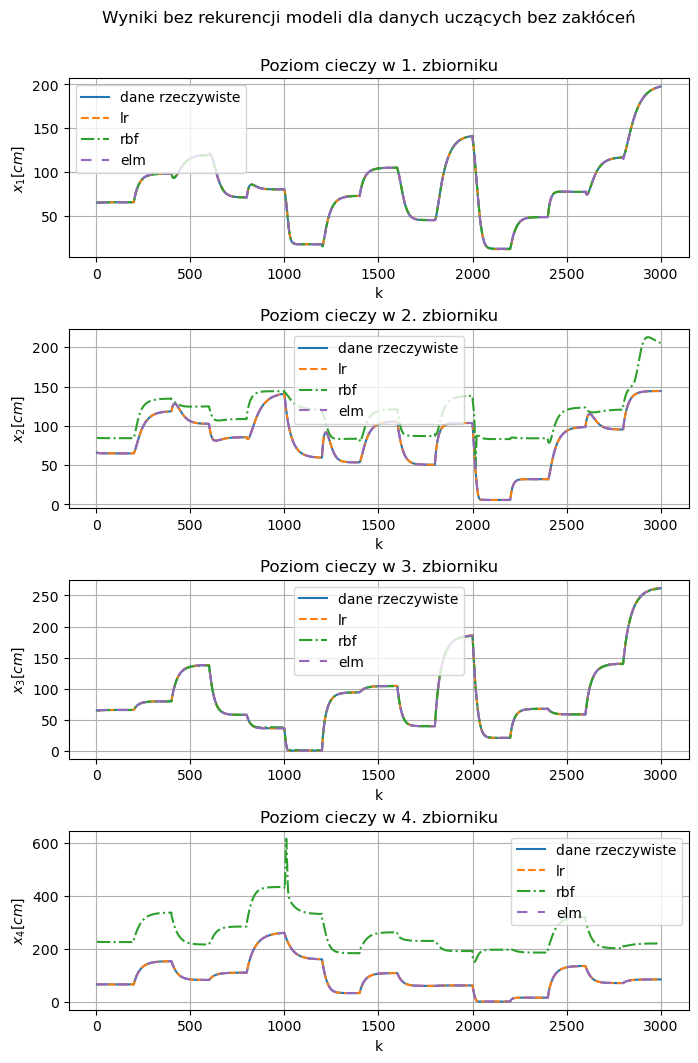

In [81]:
plot_model_result_all_tanks(df_train, dataset_name, "uczących", pred_mode)

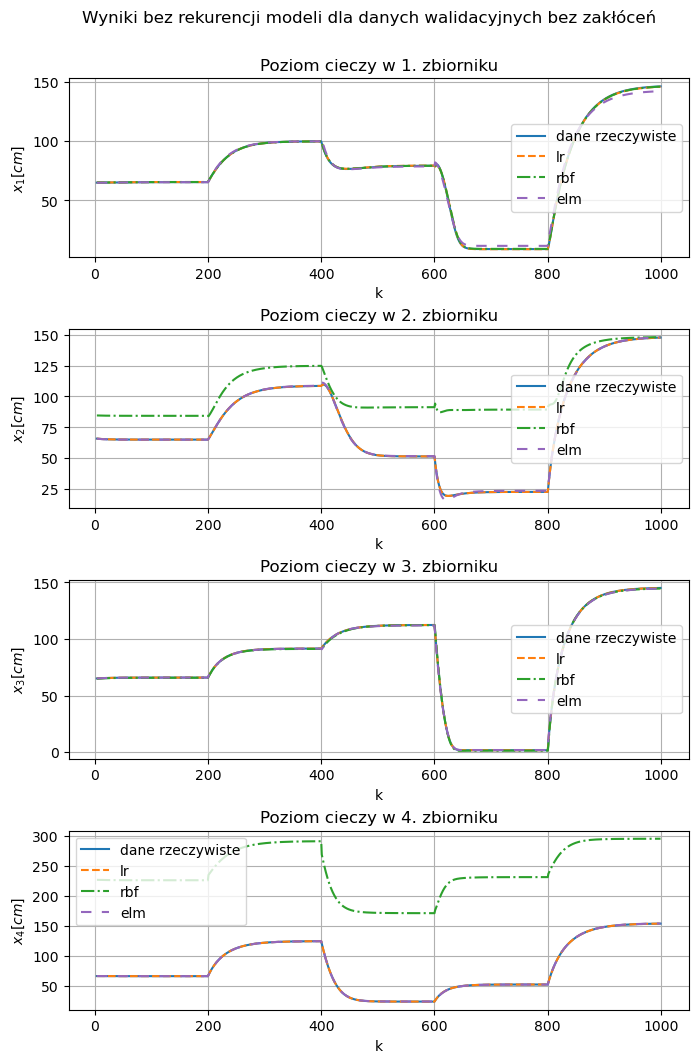

In [82]:
plot_model_result_all_tanks(df_val, dataset_name, "walidacyjnych", pred_mode)

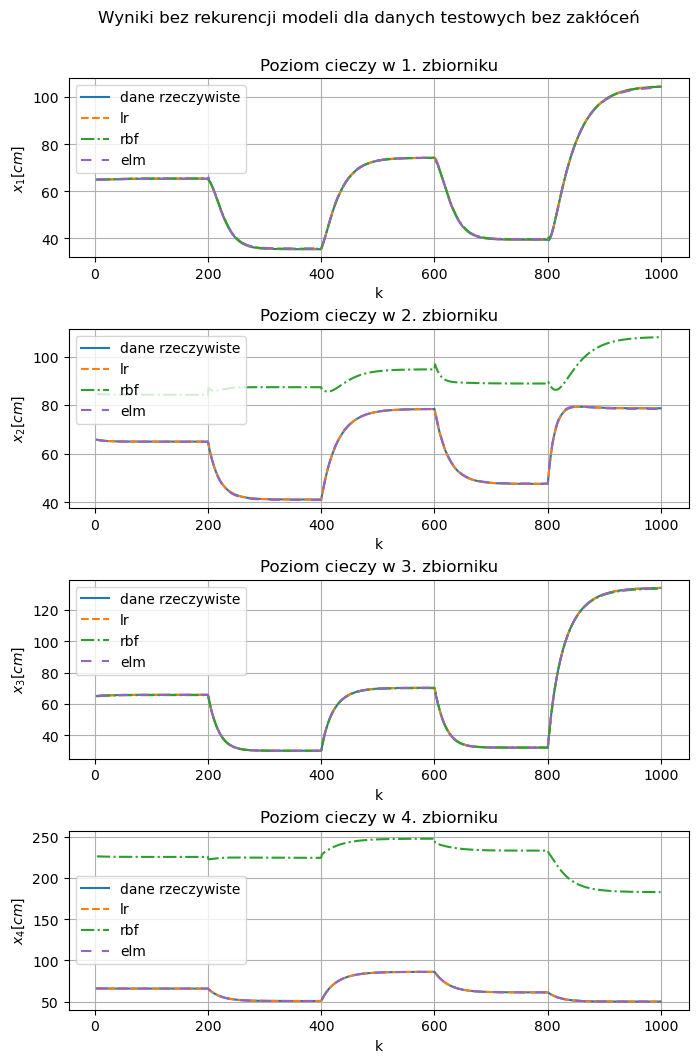

In [83]:
plot_model_result_all_tanks(df_test, dataset_name, "testowych", pred_mode)